Advanced RAG Eval notes prepared for [CAS ETH in ML in Finance and Insurance](https://finsuretech.ethz.ch/continuing-education/cas-ml-in-finance-and-insurance.html) by Eleni Verteouri.

This notebook uses Langchain

# Advanced RAG Eval

The cookbook walks through the process of running eval(s) on advanced RAG.

This can be very useful to determine the best RAG approach for your application.

In [ ]:
! pip install -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.9/273.9 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 62.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 91.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

## Data Loading

Let's look at an [example whitepaper](https://sgp.fas.org/crs/misc/IF10244.pdf) that provides a mixture of tables, text, and images about Wildfires in the US. Please upload to the files of this runtime.

In [ ]:
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 5.8 MB/s eta 0:00:00


### Option 1: Load text

In [ ]:
# Load
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("IF10244.pdf")
pdf_pages = loader.load()

# Split
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits_pypdf = text_splitter.split_documents(pdf_pages)
all_splits_pypdf_texts = [d.page_content for d in all_splits_pypdf]

In [ ]:
!apt-get install poppler-utils libpoppler-cpp-dev
!pip install -v -v python-poppler
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpoppler-cpp0v5
The following NEW packages will be installed:
  libpoppler-cpp-dev libpoppler-cpp0v5 poppler-utils
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 236 kB of archives.
After this operation, 928 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler-cpp0v5 amd64 22.02.0-2ubuntu0.3 [38.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler-cpp-dev amd64 22.02.0-2ubuntu0.3 [11.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 236 kB in 0s (1,918 kB/s)
Selecting previously unselected package libpoppler-cpp0v5:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../libpoppler-cpp0v5_22.02.

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,113 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121808 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

### Option 2: Load text, tables, images



In [ ]:
from unstructured.partition.pdf import partition_pdf

# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename="IF10244.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Store

### Option 1: Embed, store text chunks

In [ ]:
import os
import openai
os.environ["OPENAI_API_KEY"] = "your key"
openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
!pip install langchain_openai

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

baseline = Chroma.from_texts(
    texts=all_splits_pypdf_texts,
    collection_name="baseline",
    embedding=OpenAIEmbeddings(),
)
retriever_baseline = baseline.as_retriever()

### Option 2: Multi-vector retriever

#### Text Summary

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
These summaries will be embedded and used to retrieve the raw text or table elements. \
Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Text summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Apply to text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

# Apply to tables
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

#### Image Summary

In [ ]:
# Image summary chain
import base64
import io
import os
from io import BytesIO

from langchain_core.messages import HumanMessage
from PIL import Image


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = """You are an assistant tasked with summarizing images for retrieval. \
These summaries will be embedded and used to retrieve the raw image. \
Give a concise summary of the image that is well optimized for retrieval."""

# Apply to images
for img_file in sorted(os.listdir(path)):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        image_summaries.append(image_summarize(base64_image, prompt))

### Option 2a: Multi-vector retriever w/ raw images

* Return images to LLM for answer synthesis

In [ ]:
import uuid
from base64 import b64decode

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_core.documents import Document


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
multi_vector_img = Chroma(
    collection_name="multi_vector_img", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    multi_vector_img,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [ ]:
# Testing on retrieval
query = "What percentage of CPI is dedicated to Housing, and how does it compare to the combined percentage of Medical Care, Apparel, and Other Goods and Services?"
suffix_for_images = " Include any pie charts, graphs, or tables."
docs = retriever_multi_vector_img.get_relevant_documents(query + suffix_for_images)


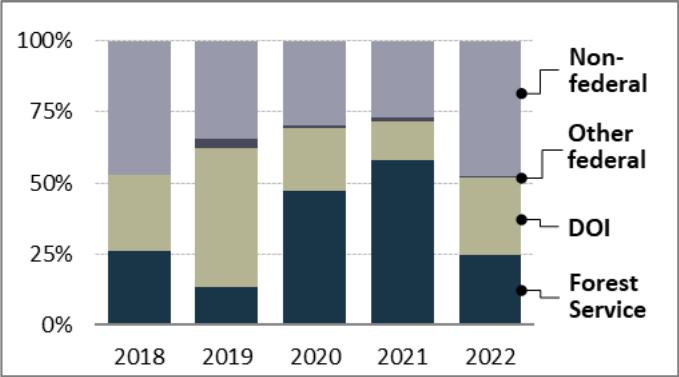

In [ ]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


plt_img_base64(docs[1])

### Option 2b: Multi-vector retriever w/ image summaries

* Return text summary of images to LLM for answer synthesis

In [ ]:
# The vectorstore to use to index the summaries
multi_vector_text = Chroma(
    collection_name="multi_vector_text", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img_summary = create_multi_vector_retriever(
    multi_vector_text,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    image_summaries,
)

### Option 3: Multi-modal embeddings

In [ ]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Create chroma w/ multi-modal embeddings
multimodal_embd = Chroma(
    collection_name="multimodal_embd", embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images and documents
if image_uris:
    multimodal_embd.add_images(uris=image_uris)
if texts:
    multimodal_embd.add_texts(texts=texts)
if tables:
    multimodal_embd.add_texts(texts=tables)

# Make retriever
retriever_multimodal_embd = multimodal_embd.as_retriever()

open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

## RAG

### Text Pipeline

In [ ]:
from operator import itemgetter

from langchain_core.runnables import RunnablePassthrough

# Prompt
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
rag_prompt_text = ChatPromptTemplate.from_template(template)


# Build
def text_rag_chain(retriever):
    """RAG chain"""

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4")

    # RAG pipeline
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | rag_prompt_text
        | model
        | StrOutputParser()
    )

    return chain

### Multi-modal Pipeline

In [ ]:
import re

from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda


def looks_like_base64(sb):
    """Check if the string looks like base64."""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """Check if the base64 data is an image by looking at the start of the data."""
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """Split base64-encoded images and texts."""
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "Answer the question based only on the provided context, which can include text, tables, and image(s). "
            "If an image is provided, analyze it carefully to help answer the question.\n"
            f"User-provided question / keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

### Build RAG Pipelines

In [ ]:
# RAG chains
chain_baseline = text_rag_chain(retriever_baseline)
chain_mv_text = text_rag_chain(retriever_multi_vector_img_summary)

# Multi-modal RAG chains
chain_multimodal_mv_img = multi_modal_rag_chain(retriever_multi_vector_img)
chain_multimodal_embd = multi_modal_rag_chain(retriever_multimodal_embd)